In [1]:
import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

# Read Data

In [2]:
mnist = input_data.read_data_sets("./data/mnist/", one_hot=True)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
image_size = 28
n_labels = 10
n_batch  = 128
n_train  = 10000
beta = 0.001

In [4]:
def accuracy(y, y_):
    return 100.0 * np.sum(np.argmax(y, 1) == np.argmax(y_, 1)) / y.shape[0]

In [5]:
with tf.variable_scope("slp"):
    x  = tf.placeholder(tf.float32, shape=(n_batch, image_size*image_size))
    y_ = tf.placeholder(tf.float32, shape=(n_batch, n_labels))
    w0 = tf.get_variable("w0", [image_size * image_size, n_labels], initializer=tf.truncated_normal_initializer(seed=0))
    b0 = tf.get_variable("b0", [n_labels], initializer=tf.constant_initializer(0.0))

    w1 = tf.get_variable("w1", [image_size * image_size, n_labels], initializer=tf.truncated_normal_initializer(seed=0))
    b1 = tf.get_variable("b1", [n_labels], initializer=tf.constant_initializer(0.0))
    
    y0 = tf.matmul( x, w0 ) + b0
    y1 = tf.matmul( x, w1 ) + b1
    


In [6]:
valid_data = mnist.validation.images
valid_labels = mnist.validation.labels
test_data = mnist.test.images
test_labels = mnist.test.labels
vx = tf.constant(valid_data)
vy_ = tf.constant(valid_labels)
tx = tf.constant(test_data)
ty_ = tf.constant(test_labels)

In [7]:
loss0 = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( y0, y_))
optimizer0 = tf.train.GradientDescentOptimizer(0.5).minimize(loss0)

loss1 = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( y1, y_) + beta * tf.nn.l2_loss(w1))
optimizer1 = tf.train.GradientDescentOptimizer(0.5).minimize(loss1)


In [8]:
train_prediction0 = tf.nn.softmax(y0)
valid_prediction0 = tf.nn.softmax(tf.matmul(vx, w0) + b0)
test_prediction0  = tf.nn.softmax(tf.matmul(tx, w0) + b0)

train_prediction1 = tf.nn.softmax(y1)
valid_prediction1 = tf.nn.softmax(tf.matmul(vx, w1) + b1)
test_prediction1  = tf.nn.softmax(tf.matmul(tx, w1) + b1)

In [9]:
sess = tf.InteractiveSession()
# sess = tf.Session()

init = tf.initialize_all_variables()

In [10]:
sess.run(init)

In [11]:
result_accuracy = []

In [12]:
for step in xrange(n_train):
    bx, by = mnist.train.next_batch(n_batch)    
    _, L0, tp0 = sess.run([optimizer0, loss0, train_prediction0], feed_dict={x: bx, y_: by})
    _, L1, tp1 = sess.run([optimizer1, loss1, train_prediction1], feed_dict={x: bx, y_: by})
    if step % 500 == 0:
        ac_wo_decay_train = accuracy(tp0, by)
        ac_wo_decay_valid = accuracy(valid_prediction0.eval(), valid_labels)
        ac_wt_decay_train = accuracy(tp1, by)
        ac_wt_decay_valid = accuracy(valid_prediction1.eval(), valid_labels)
        ac = {'step' : step, 'wo_decay' : {'training' : ac_wo_decay_train, 'validation' : ac_wo_decay_valid}, 'wt_decay' : {'training' : ac_wt_decay_train, 'validation' : ac_wt_decay_valid}}
        result_accuracy.append(ac)
        print "step = %d, train accuracy0: %.2f, validation accuracy0: %.2f, train accuracy1: %.2f, validation accuracy1: %.2f" % (step, ac_wo_decay_train, ac_wo_decay_valid, ac_wt_decay_train, ac_wt_decay_valid)
        
print "test accuracy0: %.2f" % accuracy(test_prediction0.eval(), test_labels)
print "test accuracy1: %.2f" % accuracy(test_prediction1.eval(), test_labels)

step = 0, train accuracy0: 13.28, validation accuracy0: 16.64, train accuracy1: 13.28, validation accuracy1: 16.64
step = 500, train accuracy0: 85.16, validation accuracy0: 86.24, train accuracy1: 85.94, validation accuracy1: 87.00
step = 1000, train accuracy0: 93.75, validation accuracy0: 88.78, train accuracy1: 93.75, validation accuracy1: 89.90
step = 1500, train accuracy0: 89.84, validation accuracy0: 89.48, train accuracy1: 91.41, validation accuracy1: 90.86
step = 2000, train accuracy0: 92.19, validation accuracy0: 89.94, train accuracy1: 93.75, validation accuracy1: 91.32
step = 2500, train accuracy0: 88.28, validation accuracy0: 90.24, train accuracy1: 89.84, validation accuracy1: 92.08
step = 3000, train accuracy0: 88.28, validation accuracy0: 90.32, train accuracy1: 88.28, validation accuracy1: 91.78
step = 3500, train accuracy0: 89.06, validation accuracy0: 90.46, train accuracy1: 89.84, validation accuracy1: 92.10
step = 4000, train accuracy0: 92.19, validation accuracy0: 9

/home/ohashi/anaconda2/envs/tf071/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


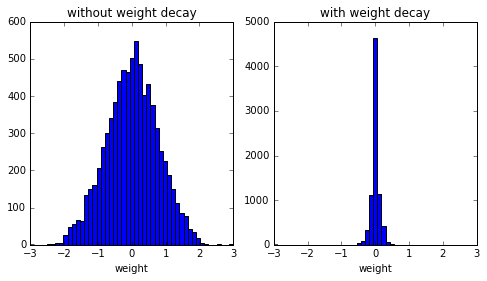

In [13]:
fig,axes = plt.subplots(ncols=2, figsize=(8,4))
axes[0].hist(w0.eval().flatten(), bins=sp.linspace(-3,3,50))
axes[0].set_title('without weight decay')
axes[0].set_xlabel('weight')
axes[1].hist(w1.eval().flatten(), bins=sp.linspace(-3,3,50))
axes[1].set_title('with weight decay')
axes[1].set_xlabel('weight')
fig.show()

In [14]:
tr_step = [ac['step'] for ac in result_accuracy]
ac_training_wo_decay = [ac['wo_decay']['training'] for ac in result_accuracy]
ac_training_wt_decay = [ac['wt_decay']['training'] for ac in result_accuracy]
ac_validation_wo_decay = [ac['wo_decay']['validation'] for ac in result_accuracy]
ac_validation_wt_decay = [ac['wt_decay']['validation'] for ac in result_accuracy]

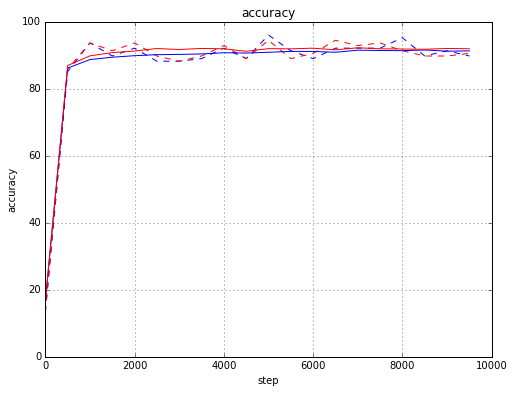

In [15]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

ax.plot(tr_step, ac_training_wo_decay, color='blue', linestyle='dashed')
ax.plot(tr_step, ac_training_wt_decay, color='red', linestyle='dashed')
ax.plot(tr_step, ac_validation_wo_decay, color='blue', linestyle='solid')
ax.plot(tr_step, ac_validation_wt_decay, color='red', linestyle='solid')
ax.set_title('accuracy')
ax.set_xlabel('step')
ax.set_ylabel('accuracy')
ax.grid(True)
ax.set_xlim((0, 10000))
ax.set_ylim((0, 100))
fig.show()